<h1 align="center">☁️ - Cloudy regions segmentation 👨‍💻🔬</h1>

<h2 align="center">EDA</h2>
<p style="text-align:center">
   Thomas Bury, Afonso Alves, Daniel Staudegger<br>
   Allianz<br>
</p>

<b style="color:darkgold"> EDA is based on this [Kaggle Kernel](https://www.kaggle.com/ekhtiar/eda-find-me-in-the-clouds/notebook)</b>


In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import yaml
import os
import swifter
import seaborn as sns
import scicomap as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import patches as patches
from pprint import pprint

# Custom package for the project, save all the functions into appropriate sub-packages
from pyreidolia.plot import set_my_plt_style, plot_cloud, plot_rnd_cloud, draw_label_only
from pyreidolia.mask import bounding_box, rle_to_mask, get_binary_mask_sum
from pyreidolia.img import get_resolution_sharpness

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport pyreidolia

# Setting global matplotlib style
If you don't like, just revert back to defaults using `plt.style.use('default')`

In [4]:
# A nicer style for mpl
set_my_plt_style(height=6, width=8, linewidth=1.5)

# A better colormap


sc_map = sc.ScicoSequential(cmap='tropical')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("tropical", sc_cmap)

# Load the config file for the paths
To avoid to hardcode the paths in a versioned file, let's create a `paths.yml` which will **not** be versioned. So that the paths are not overwritten when we pull or merge from the GitHub repo. The `paths.yml` should have a structure like:

```yml
# data
data:
  test: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/test_images/"
  train: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/train_images/"
  docs: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/"

# Path to store all notebooks, ideally not versioned
notebooks: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/notebooks/"

# Path to store all outputs (correlations, jsons, excel, etc)
output: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/output/"

# Path to store all python scripts, for versioning
scripts: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/scripts/"

# Path to studies
studies: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/studies/"

# Path to reports
reports: "C:/Users/xtbury/Documents/Projects/Pyreidolia/reports/"
```

In [5]:
def string_print(df):
    return print(df.to_string().replace('\n', '\n\t'))

In [6]:
# Where is my yaml ? "C:/Users/xtbury/Documents/Projects/Pyreidolia/paths.yml"

paths_yml = input("where is the paths.yml config file?")
with open(paths_yml, "r") as ymlfile:
    path_dic = yaml.load(ymlfile, Loader=yaml.FullLoader)

pprint(path_dic)

where is the paths.yml config file? C:/Users/xtbury/Documents/Projects/Pyreidolia/paths.yml


{'data': {'docs': 'C:/Users/xtbury/Documents/Projects/Pyreidolia/data/',
          'test': 'C:/Users/xtbury/Documents/Projects/Pyreidolia/data/test_images/',
          'train': 'C:/Users/xtbury/Documents/Projects/Pyreidolia/data/train_images/'},
 'notebooks': 'C:/Users/xtbury/Documents/Projects/Pyreidolia/notebooks/',
 'output': 'C:/Users/xtbury/Documents/Projects/Pyreidolia/output/',
 'reports': 'C:/Users/xtbury/Documents/Projects/Pyreidolia/reports/',
 'scripts': 'C:/Users/xtbury/Documents/Projects/Pyreidolia/scripts/',
 'studies': 'C:/Users/xtbury/Documents/Projects/Pyreidolia/studies/'}


In [7]:
train_csv_path = path_dic['data']['docs'] + 'train.csv'
train_data = path_dic['data']['train'] 
test_data = path_dic['data']['test'] 
report_path = path_dic['reports']

# Load the data doc

In [8]:
train_doc = pd.read_csv(train_csv_path)
print(train_doc.head())

          Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...


In [9]:
# mix of naming convention, let's fix it
train_doc = train_doc.rename({'Image_Label': 'image_label', 'EncodedPixels': 'encoded_pixels'}, axis=1)

# Prettify documentation

Split the image labels to get the type and the ID.

In [10]:
# image id and class id are two seperate entities and it makes it easier to split them up in two columns
# train_doc[] = train_doc['Image_Label'].str.split('_')[0] 
# train_doc['Label'] = train_doc['Image_Label'].str.split('_')[1] 
train_doc[['image_id', 'label']] = train_doc['image_label'].str.split('_', 1, expand=True)
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_doc['label_encodedpix'] = list(zip(train_doc['label'].values, train_doc['encoded_pixels'].values)) 
# Let's create a boolean variable if there is a mask attached to a label
train_doc['is_mask']= ~train_doc.encoded_pixels.isnull().values

train_doc.head()

image_label                                     encoded_pixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

      image_id   label                                   label_encodedpix  \
0  0011165.jpg    Fish  (Fish, 264918 937 266318 937 267718 937 269118...   
1  0011165.jpg  Flower  (Flower, 1355565 1002 1356965 1002 1358365 100...   
2  0011165.jpg  Gravel                                      (Gravel, nan)   
3  0011165.jpg   Sugar                                       (Sugar, nan)   
4  002be4f.jpg    Fish  (Fish, 233813 878 235213 878 236613 878 238010...   

   is_mask  
0     True  
1     True  
2    False  
3    False  
4     True

How many unnique image?

In [11]:
print(f"There are {train_doc.image_id.nunique()} images")

There are 5546 images


Check the unique values of `label`, if it maps what is in the paper.

In [12]:
print(train_doc.label.unique())

['Fish' 'Flower' 'Gravel' 'Sugar']


Basic information, as the number of non-null (non NaNs) and data type

# Are all the images labelled?

As we illustrate below, to each unique image corresponds 4 rows, one for each possible label. Note that there are NaN (`encoded_pixels`) because each image does not necessarily contains the 4 different cloud patterns.

In [13]:
print(train_doc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_label       22184 non-null  object
 1   encoded_pixels    11836 non-null  object
 2   image_id          22184 non-null  object
 3   label             22184 non-null  object
 4   label_encodedpix  22184 non-null  object
 5   is_mask           22184 non-null  bool  
dtypes: bool(1), object(5)
memory usage: 888.4+ KB
None


In [14]:
n_nans = train_doc.isnull().sum().loc["encoded_pixels"]
print(train_doc.isnull().sum())

image_label             0
encoded_pixels      10348
image_id                0
label                   0
label_encodedpix        0
is_mask                 0
dtype: int64


In [15]:
pprint(f"The percentage of instances without encoded_pixels: {100*n_nans/len(train_doc):.2f}%")

'The percentage of instances without encoded_pixels: 46.65%'


## How many unique values?

In [16]:
train_doc.nunique()

image_label         22184
encoded_pixels      11836
image_id             5546
label                   4
label_encodedpix    11840
is_mask                 2
dtype: int64

This summarizes what we saw above, 4 rows per image, not every image has the 4 different cloud patterns (see the distribution below).

# Labels distribution

 * Overall, non-grouped, labels distribution: select rows with a bounding box
 * Per Image labels distribution: Select instances (rows) with a bouding box, group by image ID (a image might have more than one bouding box). Then count the labels per image ID and list which are those labels.

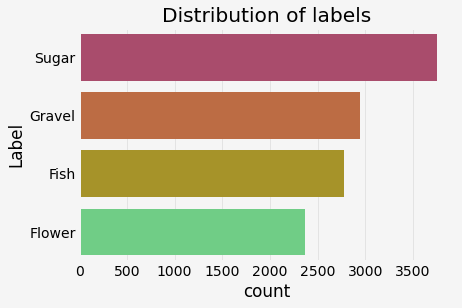

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(y='label',
                   data=train_doc.loc[train_doc.is_mask, :],
                   order=train_doc.loc[train_doc.is_mask, 'label'].value_counts().index,
                   palette='tropical');

ax.set_title('Distribution of labels')
ax.set_ylabel('Label');

Slightly non-uniform distribution, that might bias the model --> To be checked

## Pattern distribution

In [18]:
# lets group each of the types and their mask in a list so we can do more aggregated counts
# Select the rows with a bounding box using train_doc.is_bb
# group by image ID, a image might have more than 1 BB
# count the labels per image and list the attached labels
grouped_labels = train_doc.loc[train_doc.is_mask, :].groupby('image_id')[['is_mask', 'label']].agg({'is_mask': 'sum', 'label': lambda x: list(x)})
grouped_labels["label_comb"] = grouped_labels["label"].str.join("-")
print(grouped_labels.head())

             is_mask                  label         label_comb
image_id                                                      
0011165.jpg        2         [Fish, Flower]        Fish-Flower
002be4f.jpg        3  [Fish, Flower, Sugar]  Fish-Flower-Sugar
0031ae9.jpg        3  [Fish, Flower, Sugar]  Fish-Flower-Sugar
0035239.jpg        2       [Flower, Gravel]      Flower-Gravel
003994e.jpg        3  [Fish, Gravel, Sugar]  Fish-Gravel-Sugar


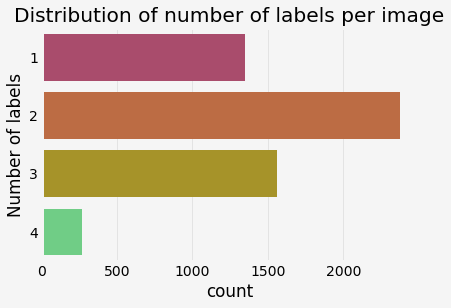

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(data=grouped_labels, y="is_mask", palette='tropical', ax=ax)
ax.set_title('Distribution of number of labels per image')
ax.set_ylabel('Number of labels');

4 types of cloud formation in one image is very rare. Only one type of cloud formation in the image is common.

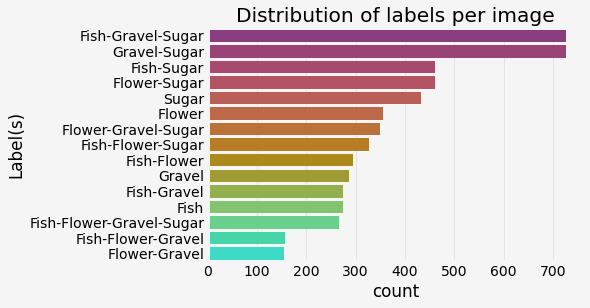

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(y='label_comb',
                   data=grouped_labels,
                   order=grouped_labels['label_comb'].value_counts().index,
                   palette='tropical')

ax.set_title('Distribution of labels per image')
ax.set_ylabel('Label(s)');

All combination of cloud formations appearing together is a possibility, and the combinations between Sugar, Fish, and Gravel are more likely than with Flower cloud formation. We note that sugar appears in 7 of the 8 most frequent patterns.

# Explore Images, masks and their bounding boxes

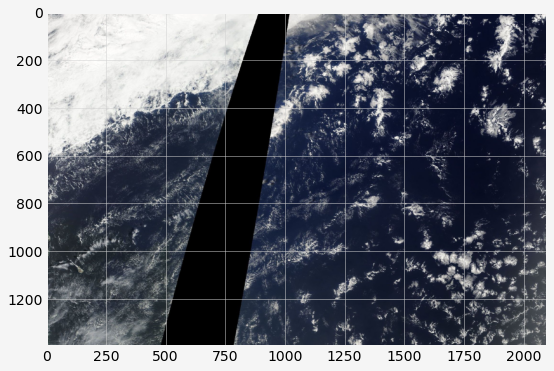

In [21]:
colors = [(0,0,255), (255,0,0), (0,255,0), (255,255,0)]
image_name = '7405a00.jpg'

rles = train_doc[train_doc['image_id']==image_name]['encoded_pixels'].reset_index(drop=True)
image_start = plt.imread(os.path.join(train_data, image_name))

fig, ax = plt.subplots()
ax.imshow(image_start) 
plt.show()

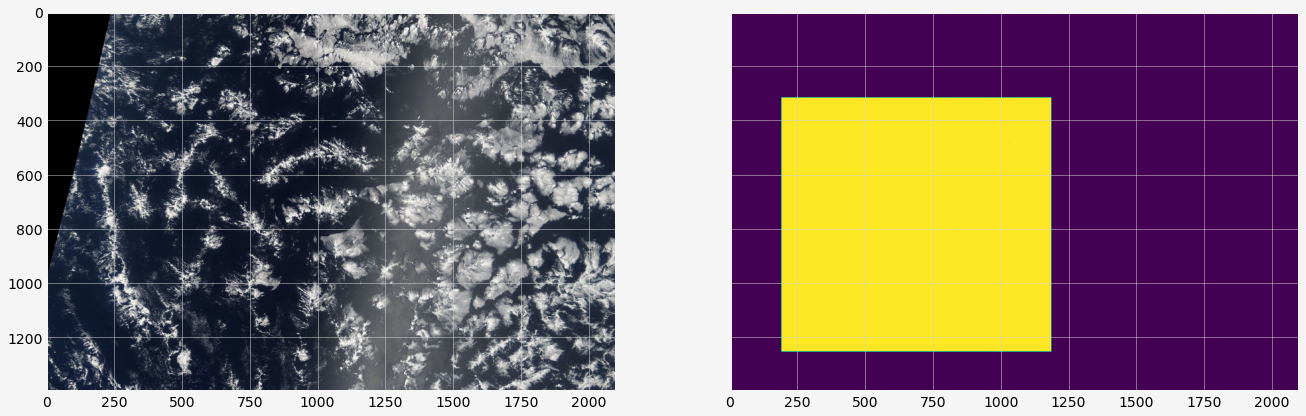

In [22]:
img = plt.imread(os.path.join(train_data, train_doc['image_id'][0]))
mask_decoded = rle_to_mask(train_doc['label_encodedpix'][0][1], size=img.shape)
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
ax[0].imshow(img)
ax[1].imshow(mask_decoded);

As explained in the paper, a mask not outlining the exact clouds but roughly the area with the same kind of patterns. The mask are generally irregular polygons. So the labels might be attached to pixels/part of the picture rather than to the whole image.

## Check cloud patterns

what do they look like?

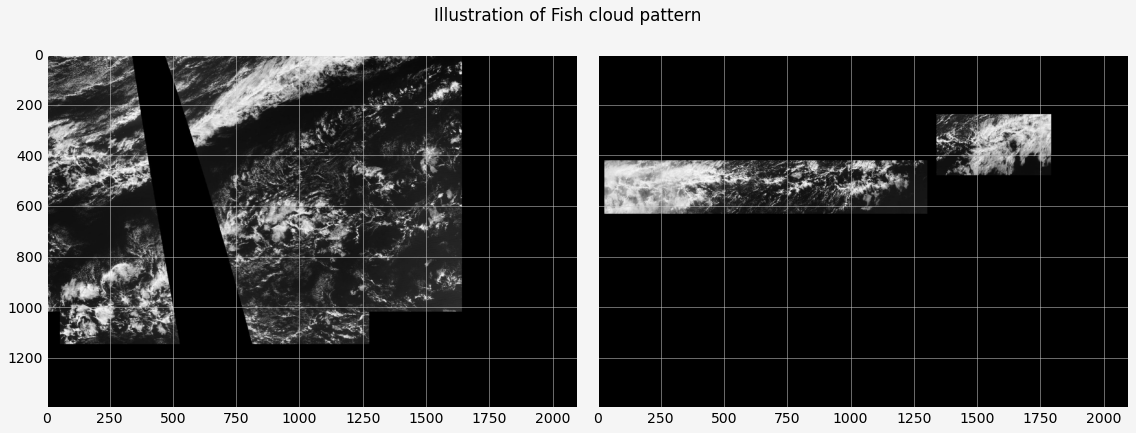

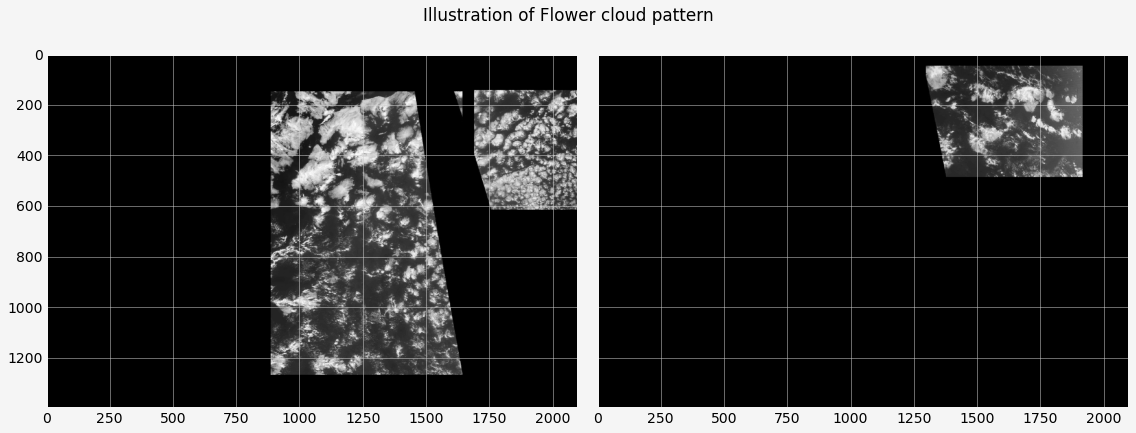

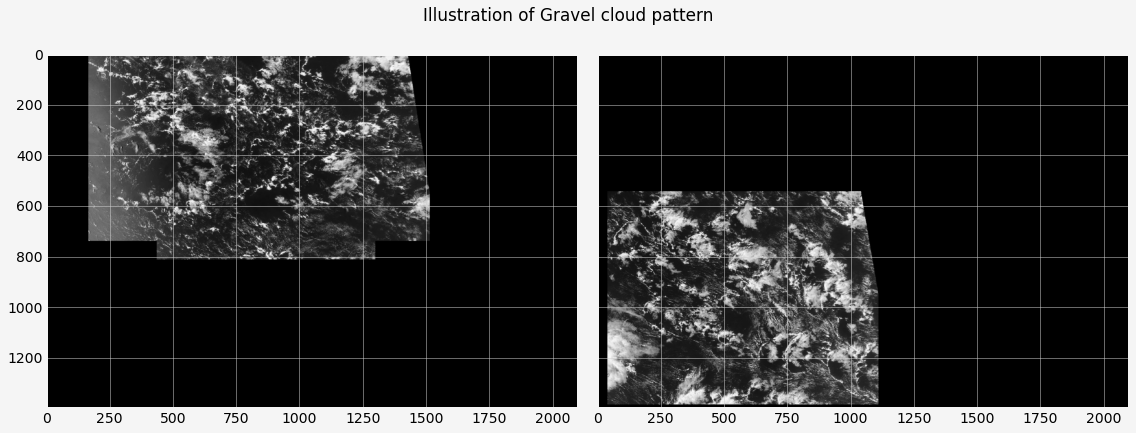

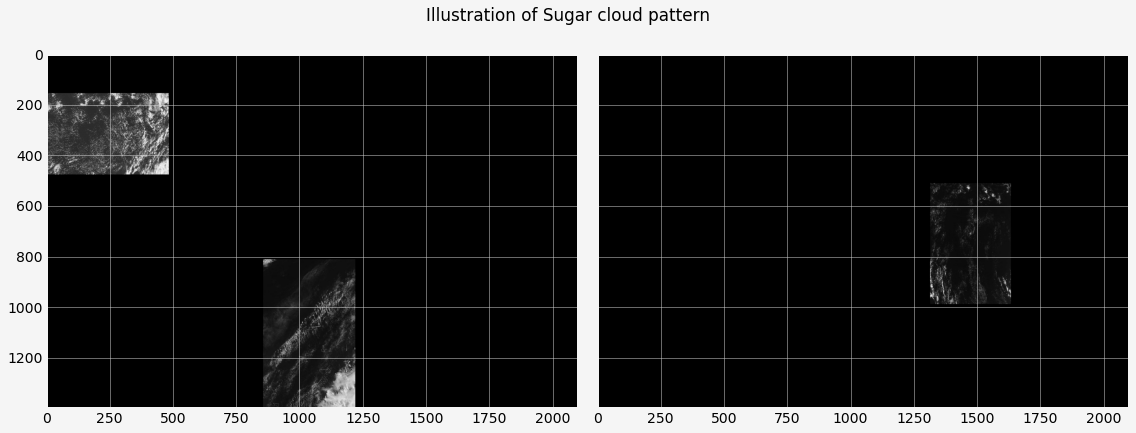

In [23]:
for label in train_doc.label.unique():
    draw_label_only(train_df=train_doc, train_path=train_data, label=label)

## Difference between mask and bouding box

See if we could use a "bouding-box" version of the mask. Is there a significant overlap? 

In [24]:
grouped_masks = train_doc.loc[train_doc.is_mask, :].groupby('image_id')['label_encodedpix'].apply(list)

In [27]:
grouped_masks

image_id
0011165.jpg    [(Fish, 264918 937 266318 937 267718 937 26911...
002be4f.jpg    [(Fish, 233813 878 235213 878 236613 878 23801...
0031ae9.jpg    [(Fish, 3510 690 4910 690 6310 690 7710 690 91...
0035239.jpg    [(Flower, 100812 462 102212 462 103612 462 105...
003994e.jpg    [(Fish, 2367966 18 2367985 2 2367993 8 2368002...
                                     ...                        
ffcedf2.jpg    [(Fish, 12631 4 12638 3 12649 16 13377 8 13395...
ffd11b6.jpg    [(Flower, 425921 5 425929 4 425945 2 425949 1 ...
ffd3dfb.jpg    [(Sugar, 12891 428 14291 428 15691 428 17091 4...
ffd6680.jpg    [(Flower, 1509467 305 1509773 7 1509782 2 1510...
ffea4f4.jpg    [(Flower, 1194860 675 1196260 675 1197660 675 ...
Name: label_encodedpix, Length: 5546, dtype: object

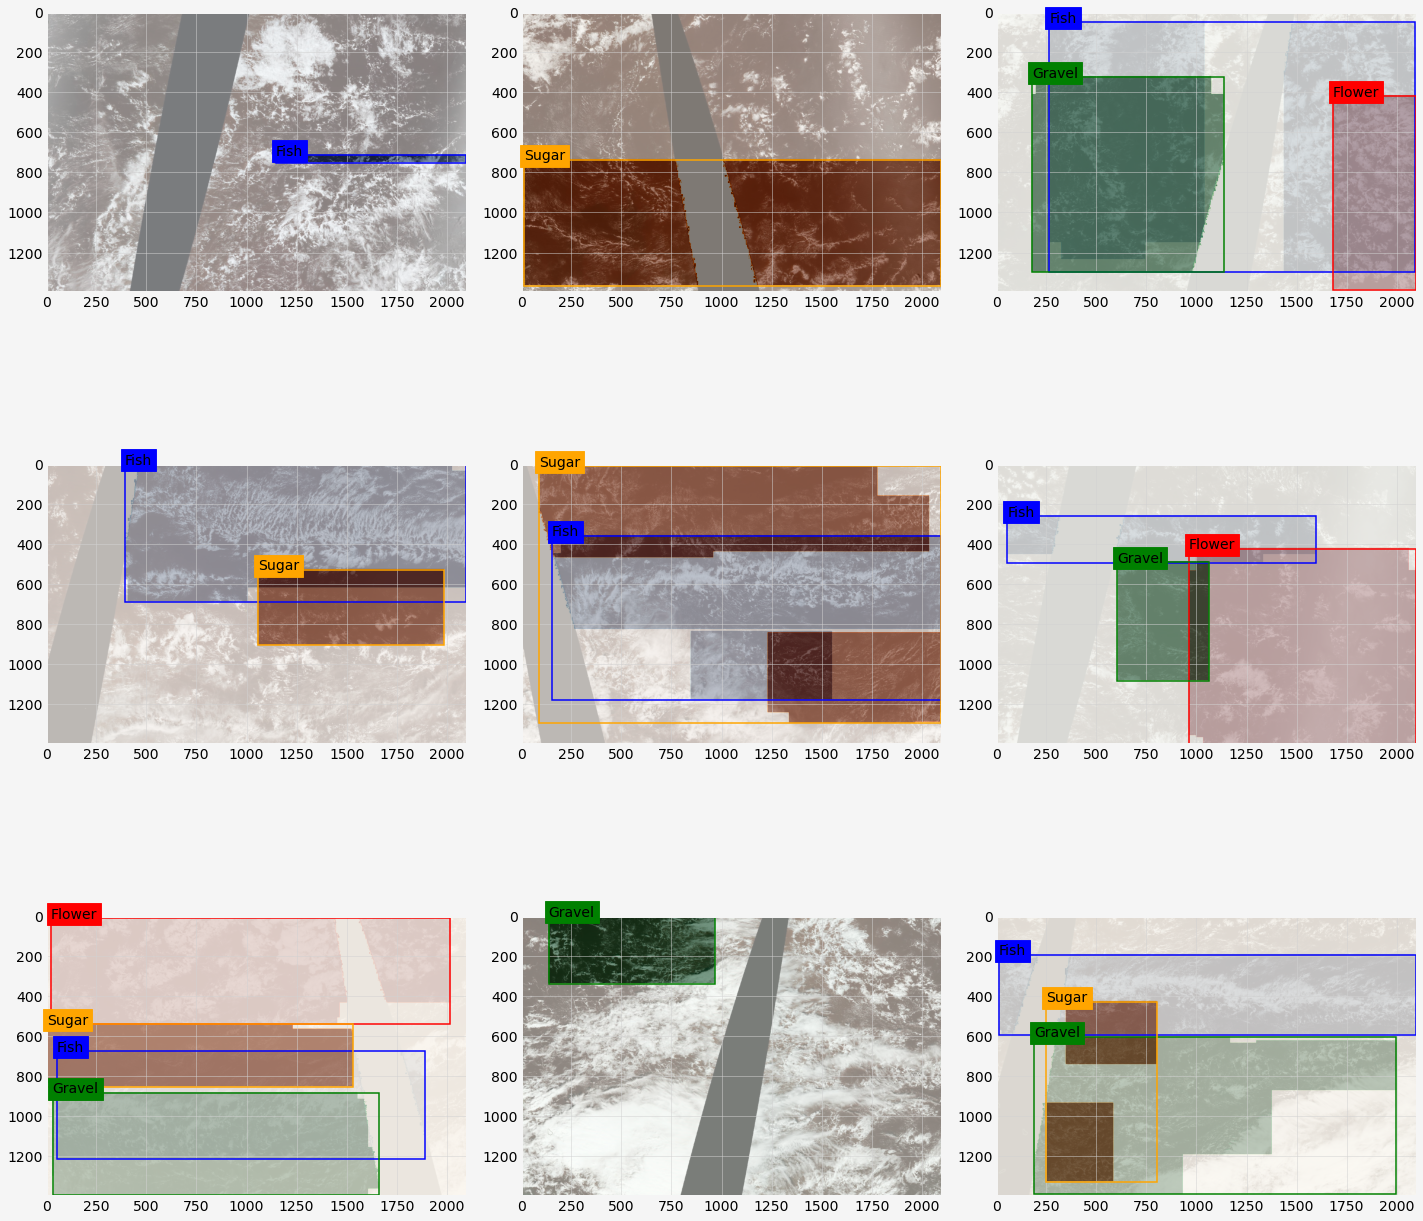

In [26]:
_ = plot_rnd_cloud(img_path=train_data, grouped_masks=grouped_masks, n_samples=9, figsize=(20,20))

# Patterns surface distribution

What is the typical surface of a given cloud formation? Are some of the patterns less extented than others?

In [52]:
%%time
# should find a faster method, athough swifter already improve compared to normal apply
train_doc['mask_pixel_sum'] = np.nan
train_doc.loc[train_doc.is_mask, 'mask_pixel_sum'] = train_doc.loc[train_doc.is_mask, :].swifter.apply(lambda x: get_binary_mask_sum(x['encoded_pixels']), axis=1)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Wall time: 2min 49s


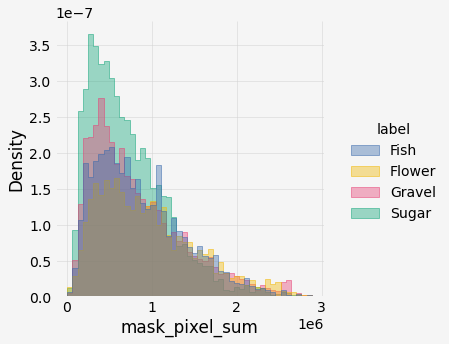

In [53]:
sns.displot(train_doc, x="mask_pixel_sum", hue="label", stat="density", element="step", alpha=.4);

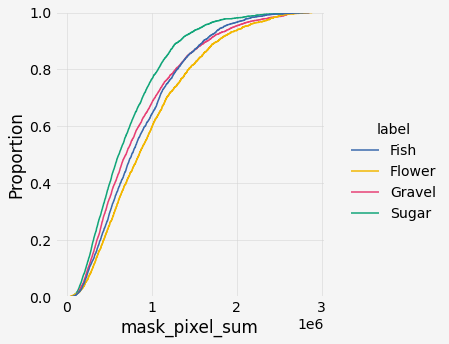

In [54]:
sns.displot(train_doc, x="mask_pixel_sum", hue="label", kind="ecdf");

It seems that the surface distributions are more or less spanning the same range. Sugar seems to be less extended (higher proba to span smaller area). Is this genuine or due to human labelling.

## Check images resolution and image sharpness (quality)

Check if all the images have the same resolution (size in pixels) and sharpness. The sharpness refers to an image’s overall clarity in terms of both focus and contrast. When the subject of an image is sharp the image appears clear and lifelike, with detail, contrast and texture rendered in high detail. If there are some images with low sharpness, we can filter them out.

In [55]:
image_res_df = pd.DataFrame({'image_id': train_doc.image_id.unique(), 'resolution': np.nan})

image_res_df[['resolution', 'sharpness']] = image_res_df['image_id'].swifter.apply(lambda x: get_resolution_sharpness(x, train_path=train_data, test_path=test_data))

image_res_df.head()

Pandas Apply:   0%|          | 0/5546 [00:00<?, ?it/s]

image_id       resolution  sharpness
0  0011165.jpg  (1400, 2100, 3)  26.944502
1  002be4f.jpg  (1400, 2100, 3)  22.857262
2  0031ae9.jpg  (1400, 2100, 3)  22.958434
3  0035239.jpg  (1400, 2100, 3)  22.417604
4  003994e.jpg  (1400, 2100, 3)  24.909672

In [56]:
print(f"The images shape is: {image_res_df.resolution.unique()}")

The images shape is: [(1400, 2100, 3)]


Let's check the sharpness distribution

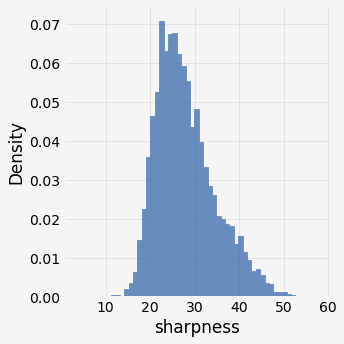

In [57]:
sns.displot(data=image_res_df, x='sharpness', stat="density", element="step");

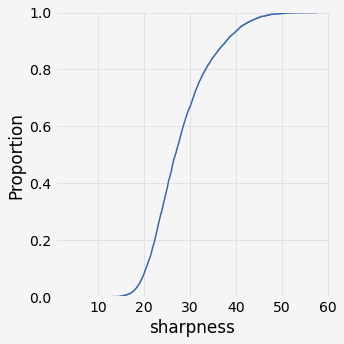

In [58]:
sns.displot(data=image_res_df, x='sharpness', kind="ecdf");

In [59]:
low_sharp_mask = image_res_df.sharpness <= 20
n_im_20s = sum(low_sharp_mask)
print(f"There are {n_im_20s} ({100*n_im_20s/len(image_res_df.sharpness):.2f}%) images with <20 sharpness")

There are 467 (8.42%) images with <20 sharpness


Let's take an example to what a low sharpness image looks like

In [60]:
image_res_df[low_sharp_mask].sort_values('sharpness').head(20)

image_id       resolution  sharpness
815   24884e7.jpg  (1400, 2100, 3)   3.304251
5275  f32724b.jpg  (1400, 2100, 3)   4.907504
1292  3b9a092.jpg  (1400, 2100, 3)   7.891079
1795  5265e81.jpg  (1400, 2100, 3)   8.726490
1399  400a38d.jpg  (1400, 2100, 3)   9.000168
2264  6723a7d.jpg  (1400, 2100, 3)  10.240151
2962  87209c5.jpg  (1400, 2100, 3)  10.407665
529   17fe76e.jpg  (1400, 2100, 3)  11.212902
2308  6949408.jpg  (1400, 2100, 3)  11.275264
4294  c647f73.jpg  (1400, 2100, 3)  11.508389
2440  6e8b086.jpg  (1400, 2100, 3)  12.681736
5333  f56bfa6.jpg  (1400, 2100, 3)  12.843396
3858  b11e1b1.jpg  (1400, 2100, 3)  13.035936
5239  f189ed1.jpg  (1400, 2100, 3)  13.827077
757   21b750d.jpg  (1400, 2100, 3)  14.124974
4220  c2f4b0b.jpg  (1400, 2100, 3)  14.348586
357   106b15a.jpg  (1400, 2100, 3)  14.391533
5206  f0188ae.jpg  (1400, 2100, 3)  14.586369
1198  37266a4.jpg  (1400, 2100, 3)  14.657312
492   166baf3.jpg  (1400, 2100, 3)  14.736301

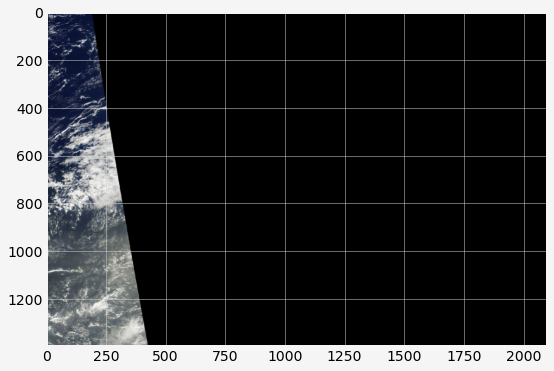

In [61]:
image_name = '24884e7.jpg'
image_start = plt.imread(os.path.join(train_data, image_name))

fig, ax = plt.subplots()
ax.imshow(image_start) 
plt.show()

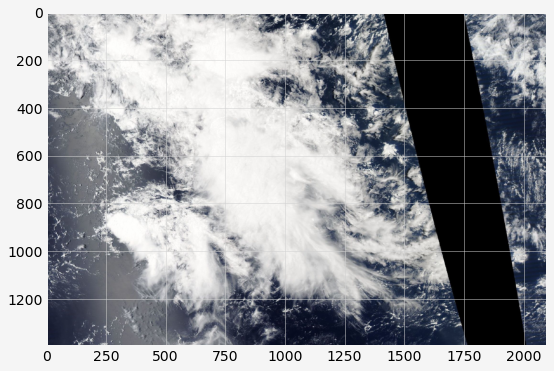

In [62]:
image_name = 'f0188ae.jpg'
image_start = plt.imread(os.path.join(train_data, image_name))

fig, ax = plt.subplots()
ax.imshow(image_start) 
plt.show()

Low sharpness images are mostly black or white (wide black stripe due to scanning or a huge cloud). Let's tag them as "bad quality".

In [63]:
image_res_df['quality'] = 'good'
image_res_df.loc[low_sharp_mask, 'quality'] = 'bad'
image_res_df[low_sharp_mask].sort_values('sharpness').head(7)

image_id       resolution  sharpness quality
815   24884e7.jpg  (1400, 2100, 3)   3.304251     bad
5275  f32724b.jpg  (1400, 2100, 3)   4.907504     bad
1292  3b9a092.jpg  (1400, 2100, 3)   7.891079     bad
1795  5265e81.jpg  (1400, 2100, 3)   8.726490     bad
1399  400a38d.jpg  (1400, 2100, 3)   9.000168     bad
2264  6723a7d.jpg  (1400, 2100, 3)  10.240151     bad
2962  87209c5.jpg  (1400, 2100, 3)  10.407665     bad

Export to parquet and csv for not having to redo the analysis (time consuming).

In [72]:
train_doc_clean = train_doc.merge(image_res_df)
train_doc_clean.to_parquet(path_dic['data']['docs'] + "train_info_clean.parquet")
train_doc_clean.to_csv(path_dic['data']['docs'] + "train_info_clean.csv", index=False)

In [73]:
train_doc_clean.head()

image_label                                     encoded_pixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

      image_id   label                                   label_encodedpix  \
0  0011165.jpg    Fish  (Fish, 264918 937 266318 937 267718 937 269118...   
1  0011165.jpg  Flower  (Flower, 1355565 1002 1356965 1002 1358365 100...   
2  0011165.jpg  Gravel                                      (Gravel, nan)   
3  0011165.jpg   Sugar                                       (Sugar, nan)   
4  002be4f.jpg    Fish  (Fish, 233813 878 235213 878 236613 878 238010...   

   is_mask  mask_pixel_sum       resolution  sharpness quality  
0     True        932312.0  (1400, 2100, 3)  26.944502    good  
1     True       1156107.0  (1400, 2100, 3)  26.944502    good  
2    False             NaN  (1400, 2100, 3)  26.944502    good  
3    False             NaN  (1400, 2100, 3)  26.944502    good  
4     True       1684325.0  (1400, 2100, 3)  22.857262    good

# Converting the notebook to Markdown

In [74]:
!jupyter nbconvert --output-dir=$report_path --no-input --to=markdown eda.ipynb

[NbConvertApp] Converting notebook eda.ipynb to markdown
[NbConvertApp] Support files will be in eda_files\
[NbConvertApp] Making directory C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/07_Reports/eda_files
[NbConvertApp] Making directory C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/07_Reports/eda_files
[NbConvertApp] Making directory C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/07_Reports/eda_files
[NbConvertApp] Making directory C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/07_Reports/eda_files
[NbConvertApp] Making directory C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/07_Reports/eda_files
[NbConvertApp] Making directory C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/07_Reports/eda_files
[NbConvertApp] Making directory C:/Users/e400086/Desktop/D

In [67]:
################## Convert to latex ##################
# Be sure to have pandoc installed, in BASE env: conda install pandoc
# !jupyter nbconvert --output-dir=$report_path --no-input --to=latex eda.ipynb

################## Convert to pdf ##################
# Be sure to have pandoc and miktex installed, in BASE env: conda install pandoc
# !jupyter nbconvert --output-dir=$report_path --no-input --to=latex eda.ipynb